<a href="https://colab.research.google.com/github/suhayb-h/Acute-Lymphoblastic-Leukemia-Classifier/blob/main/1_ALL_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Acute Lymphoblastic Leukemia Classifier:
## Preprocessing and Exploratory Data Analysis
##### Project Author: Suhayb Hafiz 

---

# Data Pre-Processing
The original validation dataset was structured differently from the training dataset. While the training folder had ALL and normal lymphoblasts divided into subfolders, the validation folder had 1867 lymphocyte images within a single folder with an accompanying CSV file that labelled these cells as 'all' or 'hem' (‘hem’ labelled healthy cells). This structuring practice caused an issue with the labelling. When training neural networks, the machine defaulted labelling 'all' as '0' and 'hem' as '1'. This was the opposite of the labelling that was used in the CSV file. For this reason, a new column was added to the testing dataframe called ‘true_labels’ before running test data through trained models. 

This process is dilineated in the four cells below:

In [1]:
"""
This cell ensures compatibility with Google Co-Lab and Google Drive importing
and should not be run if using other coding environments
"""

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import relevent libraries

import pandas as pd
import numpy as np
import glob as glob
import os
import random
import tensorflow as tf
import cv2
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential, Model
from  matplotlib import pyplot as plt
import matplotlib.image as img
%matplotlib inline
from sklearn.utils import shuffle
from tqdm import tqdm

In [3]:
# Display the original validation label dataframe
df_test = pd.read_csv(
    "/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/"
    "validation_data/C-NMC_test_prelim_phase_data_labels.csv", 
    dtype = str)
""" ^^^
Dataframe formatted as string for data generator compatability
"""
df_test

,Patient_ID,new_names,labels
0,UID_57_29_1_all.bmp,1.bmp,1
1,UID_57_22_2_all.bmp,2.bmp,1
2,UID_57_31_3_all.bmp,3.bmp,1
3,UID_H49_35_1_hem.bmp,4.bmp,0
4,UID_58_6_13_all.bmp,5.bmp,1
...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1
1863,UID_55_24_1_all.bmp,1864.bmp,1
1864,UID_H32_20_1_hem.bmp,1865.bmp,0
1865,UID_54_30_2_all.bmp,1866.bmp,1


In [4]:
# new column called true_labels was created where 'all' patients are labelled 0 
df_test.loc[df_test['Patient_ID'].str.contains('all'), 'true_labels'] = '0'

# true_labels was also given a label 1 for any patients that were non-cancerous
df_test.loc[df_test['Patient_ID'].str.contains('hem'), 'true_labels'] = '1'

df_test

,Patient_ID,new_names,labels,true_labels
0,UID_57_29_1_all.bmp,1.bmp,1,0
1,UID_57_22_2_all.bmp,2.bmp,1,0
2,UID_57_31_3_all.bmp,3.bmp,1,0
3,UID_H49_35_1_hem.bmp,4.bmp,0,1
4,UID_58_6_13_all.bmp,5.bmp,1,0
...,...,...,...,...
1862,UID_54_33_1_all.bmp,1863.bmp,1,0
1863,UID_55_24_1_all.bmp,1864.bmp,1,0
1864,UID_H32_20_1_hem.bmp,1865.bmp,0,1
1865,UID_54_30_2_all.bmp,1866.bmp,1,0


After the dataframe was appropriately modified, the next step was to assess whether the programming environment could find and categorize the dataset images based on their folder structure and organization.

In [5]:
"""
Re-structuring the training directory is required. 
Instuctions available on README file in on GitHub.
"""

data = \
tf.keras.utils.\
image_dataset_from_directory(
    '/content/drive/Othercomputers/My MacBook Air/C-NMC_Leukemia/training_data', 
    # Training set directory path^^^
    labels = "inferred", # --> Labels are extracted from folder directory
    class_names=['all', 'hem']) # --> Class names identical to folder names

Found 10661 files belonging to 2 classes.


Based on the code above, the computer was able to correctly identify 10661 images belonging to two classes within the training dataset.

# Data Analysis

The initial coding for this paper was dedicated to the analysis of cell images contained within the original dataset. Below is an assortment of 15 cells from the dataset with their appropriate labels as reproduced in the original Google Colabatory notebook. 

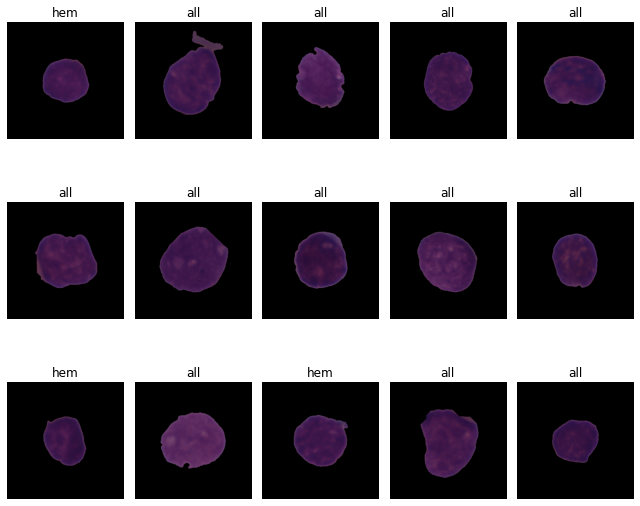

In [6]:
"""
Re-Running this cell gives a new assortment of 15 lymphoblasts labelled as 
normal (hem) or cancerous (all)
"""

class_names = data.class_names

plt.figure(figsize=(9, 8))
for images, labels in data.take(1):
  for i in range(15): # --> Plot 15 images 
    ax = plt.subplot(3, 5, i + 1) # --> Index starts from 0; +1 needed to plot
    plt.imshow(images[i].numpy().astype("uint8")) 
    # ^^^ Conversion needed to show images
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.tight_layout()

Cycling through random assortments of 15 images of lymphoblasts showcases the similarity between normal lymphoblasts and cancerous lymphoblasts. Immature cells throughout the body typically have large nuclei which allows for increased cell transcription and division. Closer inspection might reveal that cancerous lymphoblasts tend to be marginally larger and have more colour heterogeneity. However, these rules aren't followed by every image.

There are analytical techniques that can be utilized to assess whether there are truly changes in colour distribution and size between healthy lymphoblasts and cancerous lymphoblasts. Utilizing data manipulation techniques prior to machine modelling can provide useful insights as to what constitutes the differences between these two cell groups. To accomplish this task for this project, an average of every "all" cancer image was created to compare to an average of normal lymphoblasts. To create an average of images, every individual matrix representation for each image was combined into a single giant matrix. One giant matrix was created for normal cells (called hem_) and one for cancerous cells (called all_). Every image is appended to the giant matrix as a new layer. By assessing the shape of these matrices, new information can be discerned about the image data.


In [7]:
hem_ = []

for i in glob.glob(
    '/content/drive/Othercomputers/My MacBook Air/'
    'C-NMC_Leukemia/training_data/hem/*.bmp'):
    im=img.imread(i)
    hem_.append(im)

hem_array = np.array(hem_)
hem_array.shape

(3389, 450, 450, 3)

In [8]:
all_ = []

for i in glob.glob(
    '/content/drive/Othercomputers/My MacBook Air/'
    'C-NMC_Leukemia/training_data/all/*.bmp'):
    im=img.imread(i)
    all_.append(im)

all_array = np.array(all_)
all_array.shape

(7272, 450, 450, 3)

Based on the code above, the shapes of the arrays reveal that all images in the dataset are 450 by 450 pixels in size. The matrices showcased a depth of 3, which represents the three RGB colours. Assessing the shapes of both arrays showcases an obvious imbalance in the dataset, since only 3389 images were classified as normal cells and 7272 images were cancerous. From a clinical context, this imbalance makes sense because bone marrow extraction is an exceptionally painful and invasive procedure. Physicians are unlikely to order a bone marrow biopsy unless there is significant evidence that the patient might be suffering from cancer. As such, imbalance is to be expected, as most bone marrow biopsies should reveal cancerous disease more often than non-cancerous condition.

However, this imbalance can prove to be an issue during modelling. To address this issue, data could have been manipulated by randomly isolating half of cancerous images, to establish a relatively even number of images to compare between cancerous and non-cancerous states. However, this technique was ultimately decided against since having less data could also prove detrimental to model performance and reliability. For the purposes of this project, every image was utilized in model training. Instead of removing images, every neural network was assigned "weights" which allowed for normal cellular images to be assigned the weight of 2.15 cancerous cell images. These giant matrices were plotted as images below and are representative of the average of each cell class:

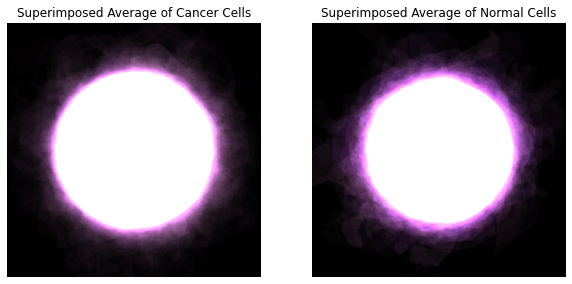

In [9]:
# Created a subplot of two images next to each other

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(all_array.mean(axis=0))
plt.title("Superimposed Average of Cancer Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hem_array.mean(axis=0))
plt.title("Superimposed Average of Normal Cells")
plt.axis("off")
plt.show()

Some interesting observations between both classes of cells can be made based on the images above. In terms of similarities, the core of both images is bright white in colour. This makes sense since every cell image in this dataset had varying presentations of the colours within the cell. Taking the average of several images cause these variations to cancel each other out, resulting in a uniform white colour. In terms of differences between these images, there are two significant observations. Firstly, the average cancer cell appears relatively large compared to the non-cancer image. The current understanding of cancer is that neoplastic cells are typically large to facilitate constant growth resulting in increased cell division. Additionally, the average cancer cell had a 'thinner' membrane compared to a non-cancer cell. This isn't necessarily a reflection of the thickness in cell membranes, but rather a reflection of average cell size. Immature cells, such as lymphoblasts, are already in a state of growth which requires relatively large nuclei. Cancer cells will be significantly more transcriptionally active compared to non-cancer lymphoblasts, which simply means that there will be more DNA replication for eventual protein synthesis. More transcription requires more DNA replication proteins, which takes up space. DNA replication almost exclusively occurs in the nucleus, which is why neoplastic cells should have larger nuclei. The result of larger nuclei, represented by the white space in these two images, is that cancer cells will typically have less space between their outer cell membrane and their nuclear envelope.

Based on the difference in the average cell size, machine learning models might be able to predict cancerous cells with a high degree of accuracy. Size and thickness of boundaries are two features that are typically easily discernable by various machine learning models. Furthermore, the high variation in thickness in the normal cell class might also result in a higher representation of colours, which is another feature that is typically easily identified by machine learning models. Isolating a small portion of both cells can allow for the comparison of their colour distributions. Comparing a small portion of the two cell stacks will allow for a better representation of the distribution of eosin (pink) colours. This technique would also prevent eosin colours from being significantly outweighed by the black and white hues which make up a majority of the image.

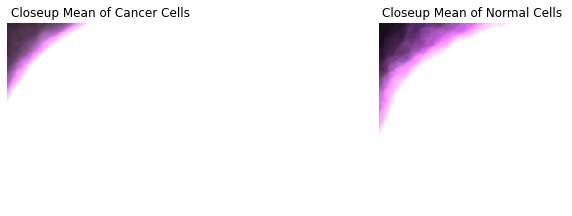

In [10]:
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.imshow(all_array[:,100:250,100:250].mean(axis=0))
plt.title("Closeup Mean of Cancer Cells")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(hem_array[:,100:250,100:250].mean(axis=0))
plt.title("Closeup Mean of Normal Cells")
plt.axis("off")

plt.subplots_adjust(wspace=1) 
plt.show()

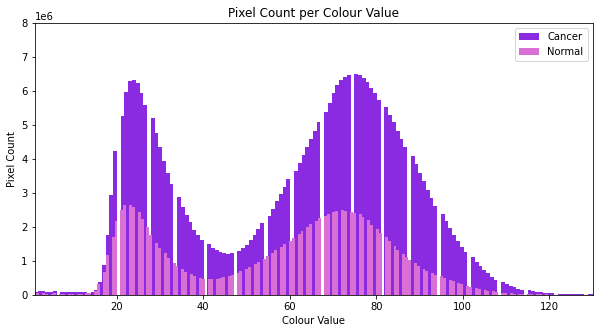

In [11]:
plt.figure(figsize = (10, 5))
plt.hist(np.ravel(all_array[:,100:250,100:250]), 
         bins=256, 
         label = 'Cancer', 
         color = 'blueviolet')
plt.hist(np.ravel(hem_array[:,100:250,100:250]), 
         bins=256, 
         label = 'Normal', 
         color = 'orchid')
plt.ylim(0,8000000) 
# ^^^ set the y limit to zoom in on the y axis to better display difference
plt.xlim(1,130) 
# ^^^ set the X limit to only show portion of the graph that shows difference
plt.xlabel('Colour Value')
plt.ylabel('Pixel Count')
plt.legend(loc='upper right')
plt.title('Pixel Count per Colour Value')
plt.show()

The above graph does show a clear over representation of colour values in cancerous cells when compared to normal cells. In order to ensure this finding is not due to the increased number of cancer cells in the dataset, a new graph was made that ensures both cell groups contain the same number of images:

In [12]:
#Create a new array that contains only the first 3389 'all' images
all_3389 = []

for i in glob.glob(
    '/content/drive/Othercomputers/My MacBook Air/'
    'C-NMC_Leukemia/training_data/all/*.bmp')\
    [1000:4389]:
    im=img.imread(i)
    all_3389.append(im)

all_3389_array = np.array(all_3389)
all_3389_array.shape

(3389, 450, 450, 3)

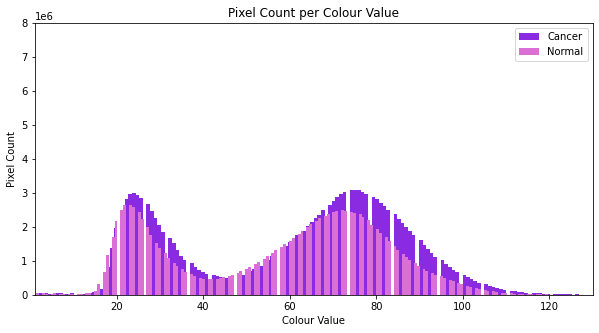

In [13]:
plt.figure(figsize = (10, 5))
plt.hist(np.ravel(all_3389_array[:,100:250,100:250]), 
         bins=256, 
         label = 'Cancer', 
         color = 'blueviolet')
plt.hist(np.ravel(hem_array[:,100:250,100:250]), 
         bins=256, 
         label = 'Normal', 
         color = 'orchid')
plt.ylim(0,8000000) # --> set y limit to zoom in on y axis to display difference
plt.xlim(1,130) # --> set X limit to only show difference
plt.xlabel('Colour Value')
plt.ylabel('Pixel Count')
plt.legend(loc='upper right')
plt.title('Pixel Count per Colour Value')
plt.show()

The above graph still reveals a surprising finding, being that the cancer cells somehow showcase a more expansive colour distribution when compared to normal lymphoblasts. This is peculiar and might require further biological testing to better understand why the cancer cell membrane might be showcasing a larger variation in colour.

The exploration of the dataset revealed that cancer cells are larger and might display a higher colour density than normal cells. Based on these features, certain machine learning models have the potential to perform well in diagnosing lymphoblasts as normal or cancerous.
